In [1]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

experiment = ""

if experiment == "":
    exps = os.listdir('experiments/')
    #exps.remove(".DS_Store")
    exps = sorted(exps, key=lambda x: datetime.datetime.strptime(x, "%d-%m-%Y--%H-%M-%S"))
    
    i = -1
    while not os.path.exists('experiments/'+exps[i]+'/baselines.csv') or not os.path.exists('experiments/'+exps[i]+'/experiments.csv'):
        i -= 1
    experiment = exps[i]
    
    print("No experiment specified, using latest experiment available:", experiment)
    
d_baselines = pd.read_csv('experiments/'+experiment+'/baselines.csv')
d_baselines.drop(columns=["Unnamed: 0"], inplace=True)

baselines_color = "red"

No experiment specified, using latest experiment available: 26-02-2024--12-29-46


In [4]:

columns = d_baselines.columns
columns = columns.drop("distance")
d = d_baselines.groupby(columns.to_list())['distance'].mean().reset_index()
d_baselines = d

d['distance'].describe()

count    24.000000
mean      0.130451
std       0.093638
min       0.015187
25%       0.058973
50%       0.109600
75%       0.202522
max       0.293804
Name: distance, dtype: float64

Distances < 0: 0 []
Distances NaN: 0 []


20520

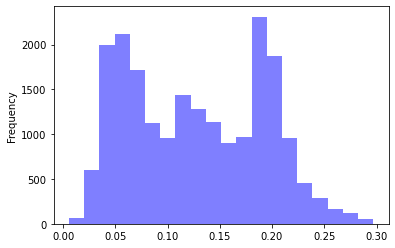

In [5]:
d_exps = pd.read_csv('experiments/'+experiment+'/experiments.csv')
d_exps.drop(columns=["Unnamed: 0"], inplace=True)

d_exps["backends_length"] = d_exps["backends"].apply(lambda x: len(x.split(",")))
#remove backends_length == 1
d_exps = d_exps[d_exps["backends_length"] > 1]

#count distances < 0 and remove
print("Distances < 0:", len(d_exps[d_exps["distance"] < 0]), list(d_exps[d_exps["distance"] < 0]["metric"]))

# count distance is nan
print("Distances NaN:", len(d_exps[d_exps["distance"].isna()]), list(d_exps[d_exps["distance"].isna()]["metric"].unique())) 

d_exps = d_exps[d_exps["distance"] > 0]


d_exps["distance"].plot.hist(bins=20, alpha=0.5, color="blue")

exps_color = "blue"

d_exps["distance"].describe()

len(d_exps)

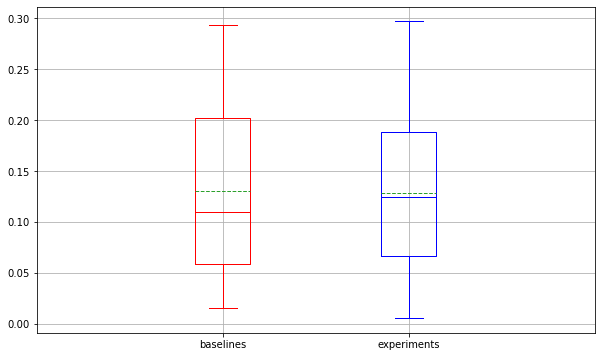

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
d_baselines[['circuit','distance']].boxplot(ax=ax, showmeans=True, meanline=True, positions=[1], color=baselines_color)
d_exps[['circuit','distance']].boxplot(ax=ax, showmeans=True, meanline=True, positions=[1.5], color=exps_color)
ax.set_xticklabels(['baselines', 'experiments'])
plt.show()

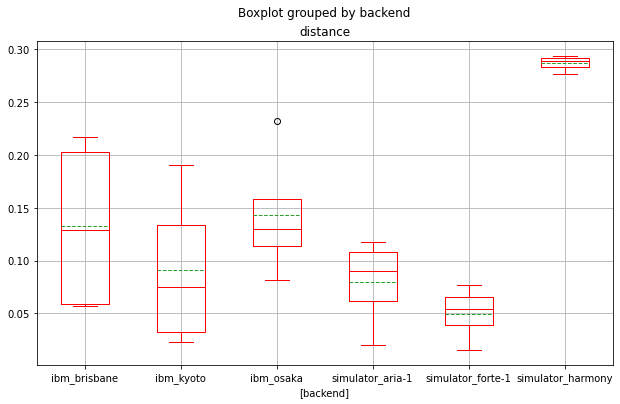

distance                                                    \
                     count      mean       std       min       25%       50%   
backend                                                                        
ibm_brisbane           4.0  0.132807  0.086528  0.056653  0.058973  0.128688   
ibm_kyoto              4.0  0.090806  0.077842  0.023132  0.032047  0.074855   
ibm_osaka              4.0  0.143072  0.063679  0.081302  0.114115  0.129409   
simulator_aria-1       4.0  0.079431  0.043197  0.019981  0.062052  0.090292   
simulator_forte-1      4.0  0.049862  0.026185  0.015187  0.038539  0.053906   
simulator_harmony      4.0  0.286730  0.007668  0.276596  0.283033  0.288259   

                                       
                        75%       max  
backend                                
ibm_brisbane       0.202522  0.217197  
ibm_kyoto          0.133614  0.190384  
ibm_osaka          0.158366  0.232169  
simulator_aria-1   0.107671  0.117159  
simulator_forte-1  0.065229  0.076448  
simulator_harmony  0.291956  0.293804

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
d_baselines[['backend','distance']].boxplot(ax=ax, showmeans=True, meanline=True, by='backend', color=baselines_color)
plt.show()
d_baselines[['backend','distance']].groupby('backend').describe()


In [7]:

def get_percentages(d_baselines, d_exps):
    percentages = {}
    for k in range(1, 11):
        percentages[k*10] = {}
        _d_baselines = d_baselines.sort_values(by="distance").head(int(len(d_baselines)*k/10))
        thresholds = {
            "min": _d_baselines["distance"].min(),
            "max": _d_baselines["distance"].max(),
            "median": _d_baselines["distance"].median(),
            "average": _d_baselines["distance"].mean()
        }
        for a, v in thresholds.items():
            percentages[k*10][a] = len(d_exps[d_exps["distance"] < v])/len(d_exps)
        
        percentages[k*10]["random"] = 0
        for i in range(1000):
            random = _d_baselines.sample(1)["distance"].values[0]
            percentages[k*10]["random"] += len(d_exps[d_exps["distance"] < random])/len(d_exps)
        percentages[k*10]["random"] /= 1000
        
    return pd.DataFrame(percentages).T * 100


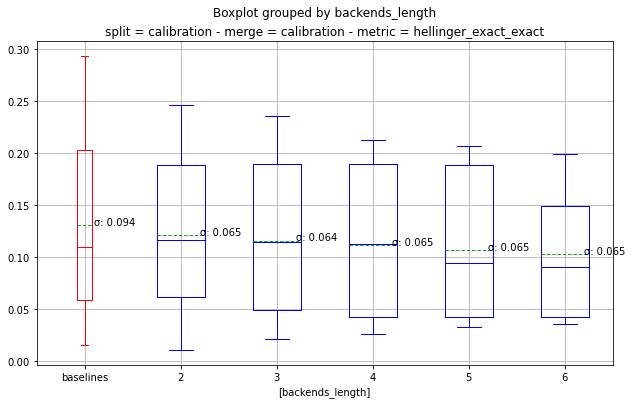

min                        max                             median        \
       2    3    4    5    6      2      3      4      5      6      2     3   
%                                                                              
10   0.8  0.0  0.0  0.0  0.0    1.0    0.0    0.0    0.0    0.0    0.8   0.0   
20   0.8  0.0  0.0  0.0  0.0    9.7    9.0    6.8    4.6    0.0    1.3   0.2   
30   0.8  0.0  0.0  0.0  0.0   23.8   26.4   33.7   41.7   50.0    9.7   9.0   
40   0.8  0.0  0.0  0.0  0.0   33.3   37.8   42.5   45.8   50.0   17.8  23.6   
50   0.8  0.0  0.0  0.0  0.0   40.7   44.8   48.3   50.4   50.0   21.5  26.0   
60   0.8  0.0  0.0  0.0  0.0   50.5   53.5   53.0   53.3   50.0   24.3  27.1   
70   0.8  0.0  0.0  0.0  0.0   58.7   61.4   62.0   60.8   60.0   30.3  33.6   
80   0.8  0.0  0.0  0.0  0.0   95.7   98.4  100.0  100.0  100.0   33.8  37.9   
90   0.8  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   36.5  39.8   
100  0.8  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   43.3  46.6   

                      average                         random              \
        4     5     6       2     3     4     5     6      2     3     4   
%                                                                          
10    0.0   0.0   0.0     0.8   0.0   0.0   0.0   0.0    0.9   0.0   0.0   
20    0.0   0.0   0.0     2.0   0.2   0.0   0.0   0.0    3.5   2.3   1.7   
30    6.8   4.6   0.0    11.7  12.0  10.5   7.9   2.5   11.3  12.0  16.1   
40   31.7  38.3  37.5    17.2  22.2  29.0  28.7  32.5   14.9  17.0  20.4   
50   33.7  41.7  50.0    19.2  25.4  33.3  41.7  50.0   20.7  23.5  26.9   
60   33.7  41.7  50.0    26.2  29.4  35.3  41.7  50.0   24.7  26.6  29.9   
70   38.2  44.2  50.0    31.8  35.2  40.5  45.4  50.0   28.6  32.0  33.4   
80   42.5  45.8  50.0    39.3  41.8  47.8  50.0  50.0   38.0  38.2  42.6   
90   44.0  47.9  50.0    42.5  46.2  48.3  50.4  50.0   43.6  46.1  48.5   
100  48.7  50.4  50.0    56.8  59.2  58.0  55.4  50.0   51.8  50.5  53.4   

                 
        5     6  
%                
10    0.0   0.0  
20    1.2   0.0  
30   17.8  21.0  
40   23.3  25.9  
50   29.5  33.1  
60   33.1  34.9  
70   35.4  37.1  
80   45.7  44.3  
90   49.6  50.4  
100  58.5  56.2

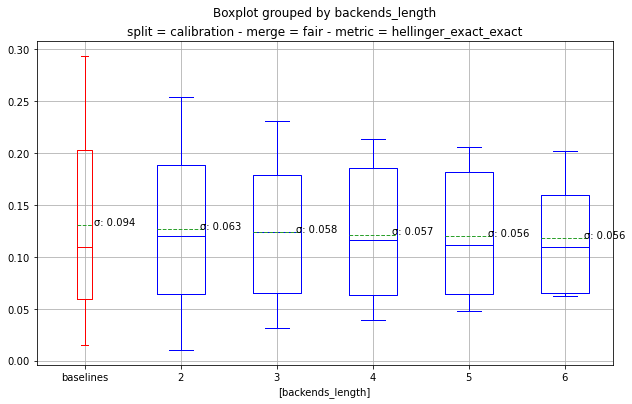

min                        max                             median        \
       2    3    4    5    6      2      3      4      5      6      2     3   
%                                                                              
10   0.5  0.0  0.0  0.0  0.0    1.2    0.0    0.0    0.0    0.0    0.8   0.0   
20   0.5  0.0  0.0  0.0  0.0    5.0    0.9    0.0    0.0    0.0    1.3   0.0   
30   0.5  0.0  0.0  0.0  0.0   20.2   19.5   19.8   14.2    0.0    5.0   0.9   
40   0.5  0.0  0.0  0.0  0.0   30.3   31.2   34.7   40.4   50.0   12.0   8.1   
50   0.5  0.0  0.0  0.0  0.0   42.0   41.9   45.0   47.9   50.0   19.2  18.8   
60   0.5  0.0  0.0  0.0  0.0   49.5   48.5   50.2   50.4   50.0   21.2  20.8   
70   0.5  0.0  0.0  0.0  0.0   52.8   54.9   55.5   54.2   50.0   27.2  28.6   
80   0.5  0.0  0.0  0.0  0.0   96.5   97.9  100.0  100.0  100.0   30.3  31.2   
90   0.5  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   31.5  31.9   
100  0.5  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   45.3  44.1   

                      average                         random              \
        4     5     6       2     3     4     5     6      2     3     4   
%                                                                          
10    0.0   0.0   0.0     0.8   0.0   0.0   0.0   0.0    0.8   0.0   0.0   
20    0.0   0.0   0.0     1.7   0.0   0.0   0.0   0.0    2.0   0.2   0.0   
30    0.0   0.0   0.0     5.5   1.4   0.0   0.0   0.0    8.4   6.5   5.3   
40    3.7   0.0   0.0    10.5   5.8   2.2   0.0   0.0   12.2  11.8  10.1   
50   17.0  10.8   0.0    17.0  15.6  11.3   5.4   0.0   17.5  17.2  17.1   
60   20.7  16.7   0.0    23.7  24.0  25.2  23.3  15.0   22.6  22.0  22.6   
70   31.8  34.6  40.0    29.2  30.2  33.8  36.7  47.5   26.0  25.4  26.7   
80   34.7  40.8  50.0    35.3  36.0  40.7  45.8  50.0   34.7  32.9  35.4   
90   35.0  41.7  50.0    44.2  43.2  46.8  50.0  50.0   42.1  42.1  42.3   
100  48.0  50.0  50.0    52.0  53.0  54.8  54.2  50.0   50.6  48.2  48.7   

                 
        5     6  
%                
10    0.0   0.0  
20    0.0   0.0  
30    3.2   0.0  
40    8.8   5.8  
50   16.9  16.8  
60   23.1  21.4  
70   26.5  24.3  
80   37.8  36.6  
90   42.5  41.7  
100  49.2  49.2

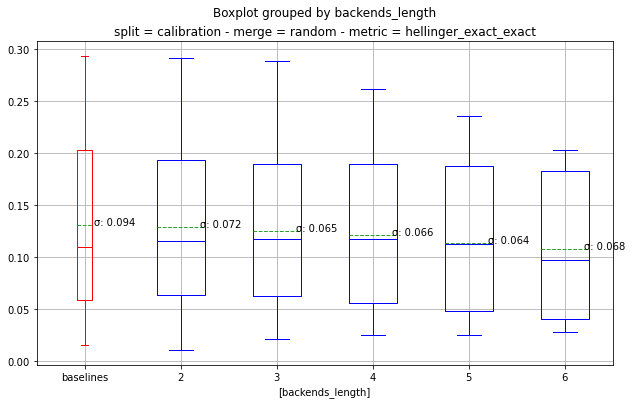

min                        max                             median        \
       2    3    4    5    6      2      3      4      5      6      2     3   
%                                                                              
10   0.8  0.0  0.0  0.0  0.0    1.3    0.0    0.0    0.0    0.0    0.8   0.0   
20   0.8  0.0  0.0  0.0  0.0    5.5    5.2    6.7    6.7   10.0    1.3   0.1   
30   0.8  0.0  0.0  0.0  0.0   21.2   22.8   27.3   32.5   42.5    5.5   5.2   
40   0.8  0.0  0.0  0.0  0.0   33.5   32.8   35.5   41.2   50.0   11.7  14.0   
50   0.8  0.0  0.0  0.0  0.0   44.0   41.6   43.7   47.5   50.0   19.2  21.5   
60   0.8  0.0  0.0  0.0  0.0   51.2   49.8   50.0   55.8   50.0   22.7  23.4   
70   0.8  0.0  0.0  0.0  0.0   56.7   57.9   58.5   62.9   57.5   29.0  29.6   
80   0.8  0.0  0.0  0.0  0.0   86.8   93.5   96.2   99.6  100.0   33.7  32.8   
90   0.8  0.0  0.0  0.0  0.0   98.8   99.9  100.0  100.0  100.0   35.5  34.0   
100  0.8  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   46.2  44.6   

                      average                         random              \
        4     5     6       2     3     4     5     6      2     3     4   
%                                                                          
10    0.0   0.0   0.0     0.8   0.0   0.0   0.0   0.0    1.1   0.0   0.0   
20    0.0   0.0   0.0     1.8   0.4   0.0   0.0   0.0    2.4   1.4   1.8   
30    6.7   6.7  10.0     6.7   6.4   7.8   7.1  17.5    8.8   8.9  11.2   
40   18.8  23.3  32.5    10.7  11.9  16.7  19.6  32.5   13.4  12.7  15.8   
50   26.2  31.2  42.5    16.0  18.8  24.2  29.2  42.5   18.7  18.4  22.1   
60   27.5  33.8  42.5    24.8  25.8  29.2  35.8  42.5   23.5  23.3  25.2   
70   32.3  38.3  47.5    31.5  31.0  33.7  39.2  47.5   28.3  28.0  29.1   
80   35.8  41.2  50.0    41.2  38.6  41.5  44.2  50.0   36.2  36.6  37.6   
90   37.5  41.7  50.0    45.7  43.5  44.7  48.8  50.0   41.7  44.2  44.1   
100  45.8  48.8  50.0    56.2  56.4  56.2  62.1  57.5   49.1  48.9  51.2   

                 
        5     6  
%                
10    0.0   0.0  
20    1.7   2.5  
30   14.0  18.2  
40   18.4  25.8  
50   23.5  30.5  
60   27.8  32.5  
70   33.8  36.4  
80   41.1  44.5  
90   45.8  50.3  
100  54.5  55.6

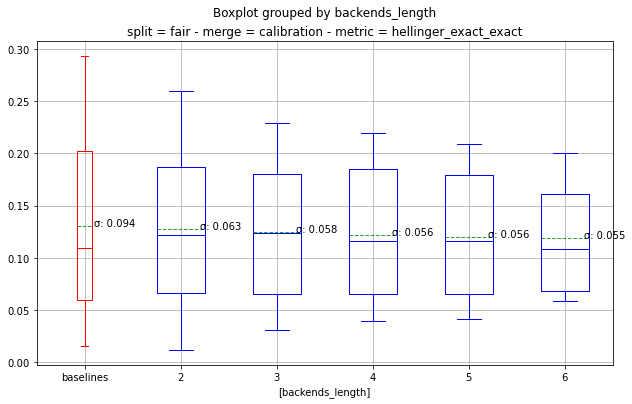

min                        max                             median        \
       2    3    4    5    6      2      3      4      5      6      2     3   
%                                                                              
10   0.2  0.0  0.0  0.0  0.0    1.3    0.0    0.0    0.0    0.0    0.8   0.0   
20   0.2  0.0  0.0  0.0  0.0    4.5    0.4    0.0    0.0    0.0    1.5   0.0   
30   0.2  0.0  0.0  0.0  0.0   19.8   20.0   18.0   11.7    5.0    4.5   0.4   
40   0.2  0.0  0.0  0.0  0.0   30.2   31.0   34.7   41.7   50.0   11.7   6.8   
50   0.2  0.0  0.0  0.0  0.0   41.7   42.0   44.2   48.8   50.0   18.8  18.2   
60   0.2  0.0  0.0  0.0  0.0   49.2   48.5   50.2   50.0   50.0   20.7  20.8   
70   0.2  0.0  0.0  0.0  0.0   53.0   54.4   55.8   54.6   50.0   27.7  28.2   
80   0.2  0.0  0.0  0.0  0.0   96.2   98.0   99.7  100.0  100.0   30.3  31.1   
90   0.2  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   32.2  31.5   
100  0.2  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   44.8  44.5   

                      average                         random              \
        4     5     6       2     3     4     5     6      2     3     4   
%                                                                          
10    0.0   0.0   0.0     0.8   0.0   0.0   0.0   0.0    0.8   0.0   0.0   
20    0.0   0.0   0.0     1.7   0.0   0.0   0.0   0.0    1.9   0.1   0.0   
30    0.0   0.0   0.0     5.2   0.8   0.0   0.0   0.0    7.9   6.0   4.8   
40    3.0   0.4   0.0     9.8   5.0   2.0   0.4   0.0   11.3  10.6   9.9   
50   15.5   8.3   0.0    16.8  13.9  11.2   5.0   0.0   18.0  17.2  16.4   
60   19.2  13.3   5.0    23.3  23.9  23.2  19.2  15.0   22.4  21.6  22.3   
70   29.3  34.2  30.0    29.3  29.8  33.0  39.2  47.5   26.1  25.1  26.3   
80   34.7  41.7  50.0    35.2  35.9  40.7  45.4  50.0   35.0  36.8  36.4   
90   35.0  42.1  50.0    43.7  43.1  46.3  49.2  50.0   40.3  42.5  43.5   
100  47.8  49.2  50.0    52.2  53.6  54.8  54.2  50.0   49.1  49.8  49.9   

                 
        5     6  
%                
10    0.0   0.0  
20    0.0   0.0  
30    3.1   0.7  
40    9.0   6.6  
50   18.6  18.4  
60   21.8  22.3  
70   26.2  24.1  
80   36.6  38.3  
90   44.4  41.3  
100  49.1  48.2

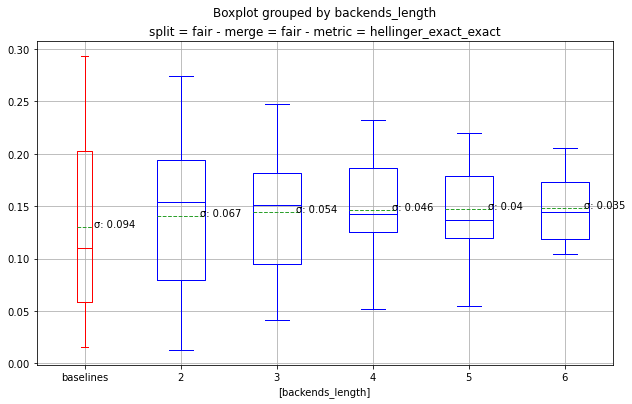

min                        max                             median        \
       2    3    4    5    6      2      3      4      5      6      2     3   
%                                                                              
10   0.2  0.0  0.0  0.0  0.0    1.3    0.0    0.0    0.0    0.0    0.8   0.0   
20   0.2  0.0  0.0  0.0  0.0    1.7    0.0    0.0    0.0    0.0    1.5   0.0   
30   0.2  0.0  0.0  0.0  0.0   12.2    6.6    4.3    2.1    0.0    1.7   0.0   
40   0.2  0.0  0.0  0.0  0.0   23.8   19.5   11.2    4.6    0.0    5.5   0.9   
50   0.2  0.0  0.0  0.0  0.0   41.0   29.8   18.3    8.3    2.5   11.5   5.8   
60   0.2  0.0  0.0  0.0  0.0   42.3   30.0   18.3   20.4   25.0   12.7   7.5   
70   0.2  0.0  0.0  0.0  0.0   45.0   31.6   38.3   45.0   50.0   20.8  14.5   
80   0.2  0.0  0.0  0.0  0.0   87.3   91.5   96.0   98.8  100.0   23.8  19.6   
90   0.2  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   26.8  21.6   
100  0.2  0.0  0.0  0.0  0.0  100.0  100.0  100.0  100.0  100.0   41.5  30.0   

                     average                         random                    \
        4    5     6       2     3     4     5     6      2     3     4     5   
%                                                                               
10    0.0  0.0   0.0     0.8   0.0   0.0   0.0   0.0    0.7   0.0   0.0   0.0   
20    0.0  0.0   0.0     1.7   0.0   0.0   0.0   0.0    1.2   0.0   0.0   0.0   
30    0.0  0.0   0.0     1.8   0.0   0.0   0.0   0.0    4.7   1.8   0.9   0.4   
40    0.0  0.0   0.0     4.0   0.5   0.0   0.0   0.0    7.8   4.4   2.5   1.1   
50    3.3  1.7   0.0     9.5   3.8   1.2   0.0   0.0   13.4   9.3   5.9   2.5   
60    4.5  2.1   0.0    15.5   9.9   6.0   3.8   0.0   17.1  11.9   6.9   4.7   
70    9.5  4.2   0.0    22.0  17.4  10.2   4.2   0.0   20.1  15.0  10.0   9.6   
80   11.5  5.0   0.0    35.3  24.1  17.5   8.3   0.0   30.1  22.8  22.0  21.2   
90   12.3  7.5   0.0    41.3  30.0  18.3   8.3  12.5   35.4  32.6  31.4  28.0   
100  18.3  9.6  17.5    45.0  31.1  33.0  42.1  50.0   44.5  40.7  38.8  38.8   

           
        6  
%          
10    0.0  
20    0.0  
30    0.0  
40    0.0  
50    0.2  
60    4.0  
70    8.5  
80   20.6  
90   29.5  
100  39.0

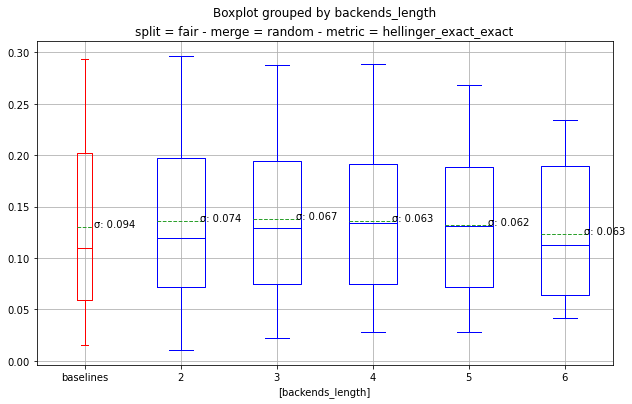

min                       max                             median        \
       2    3    4    5    6     2      3      4      5      6      2     3   
%                                                                             
10   0.7  0.0  0.0  0.0  0.0   1.5    0.0    0.0    0.0    0.0    0.8   0.0   
20   0.7  0.0  0.0  0.0  0.0   2.8    0.8    0.8    1.7    0.0    1.8   0.0   
30   0.7  0.0  0.0  0.0  0.0  16.8   15.4   15.7   17.9   20.0    2.8   0.8   
40   0.7  0.0  0.0  0.0  0.0  27.5   26.1   25.7   27.1   40.0    8.3   5.8   
50   0.7  0.0  0.0  0.0  0.0  42.0   38.0   35.3   37.9   50.0   15.7  14.0   
60   0.7  0.0  0.0  0.0  0.0  48.2   44.0   41.2   41.2   50.0   17.3  15.8   
70   0.7  0.0  0.0  0.0  0.0  55.8   51.9   50.0   52.1   60.0   23.3  21.8   
80   0.7  0.0  0.0  0.0  0.0  80.7   85.1   90.8   92.9   95.0   27.7  26.5   
90   0.7  0.0  0.0  0.0  0.0  97.0   99.2   99.7  100.0  100.0   32.5  29.0   
100  0.7  0.0  0.0  0.0  0.0  99.8  100.0  100.0  100.0  100.0   44.7  40.2   

                      average                         random              \
        4     5     6       2     3     4     5     6      2     3     4   
%                                                                          
10    0.0   0.0   0.0     0.8   0.0   0.0   0.0   0.0    1.1   0.0   0.0   
20    0.0   0.0   0.0     2.0   0.1   0.0   0.0   0.0    1.8   0.2   0.2   
30    0.8   1.7   0.0     3.5   1.0   1.7   2.1   0.0    6.7   5.2   4.8   
40    6.0   7.1   2.5     7.0   4.6   4.3   5.0   2.5   10.2   8.2   8.4   
50   14.3  17.5  17.5    12.8  11.5  12.2  13.3   7.5   17.0  14.6  13.5   
60   15.8  18.3  20.0    19.7  18.4  18.5  19.2  22.5   20.8  18.3  18.1   
70   21.8  23.3  27.5    25.0  23.1  23.5  25.0  32.5   25.6  22.6  21.5   
80   26.0  27.9  40.0    37.3  33.0  31.7  35.0  47.5   33.2  31.9  30.9   
90   28.5  30.4  40.0    43.8  39.0  36.2  38.8  50.0   37.5  37.3  38.1   
100  37.2  39.2  50.0    54.2  50.9  47.7  49.6  55.0   46.0  46.2  45.4   

                 
        5     6  
%                
10    0.0   0.0  
20    0.4   0.0  
30    6.4   4.7  
40   10.1   9.3  
50   15.2  18.3  
60   18.2  23.7  
70   21.9  27.4  
80   32.1  35.5  
90   37.4  42.7  
100  45.2  47.9

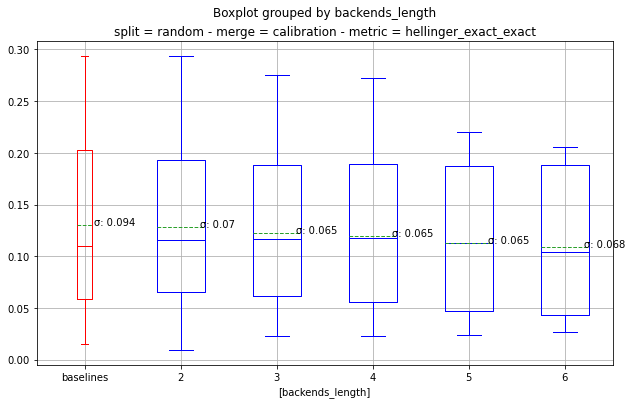

min                       max                             median        \
       2    3    4    5    6     2      3      4      5      6      2     3   
%                                                                             
10   1.0  0.0  0.0  0.0  0.0   1.2    0.0    0.0    0.0    0.0    1.0   0.0   
20   1.0  0.0  0.0  0.0  0.0   4.7    5.5    5.5    6.2   10.0    1.2   0.0   
30   1.0  0.0  0.0  0.0  0.0  20.5   22.4   26.8   36.2   45.0    4.7   5.5   
40   1.0  0.0  0.0  0.0  0.0  32.0   33.9   38.0   42.9   47.5   12.0  15.6   
50   1.0  0.0  0.0  0.0  0.0  42.3   43.8   45.7   47.9   50.0   19.3  21.8   
60   1.0  0.0  0.0  0.0  0.0  50.2   51.0   49.8   51.7   50.0   21.8  23.9   
70   1.0  0.0  0.0  0.0  0.0  56.5   58.5   58.2   61.3   60.0   27.5  29.5   
80   1.0  0.0  0.0  0.0  0.0  87.7   93.8   96.3   98.3  100.0   32.0  34.2   
90   1.0  0.0  0.0  0.0  0.0  99.3  100.0  100.0  100.0  100.0   34.8  35.9   
100  1.0  0.0  0.0  0.0  0.0  99.8  100.0  100.0  100.0  100.0   45.3  45.9   

                      average                         random              \
        4     5     6       2     3     4     5     6      2     3     4   
%                                                                          
10    0.0   0.0   0.0     1.0   0.0   0.0   0.0   0.0    1.1   0.0   0.0   
20    0.0   0.0   0.0     2.2   0.1   0.2   0.0   0.0    2.1   1.5   1.2   
30    5.5   6.2  10.0     5.2   6.8   7.2   8.3  12.5    8.7   9.3  10.6   
40   17.8  24.2  32.5    11.0  14.0  15.7  19.2  27.5   12.6  13.7  15.8   
50   26.2  35.4  45.0    16.7  19.1  24.2  32.1  37.5   18.8  20.1  23.1   
60   27.8  36.2  45.0    23.3  26.4  29.7  36.7  47.5   22.8  24.4  26.3   
70   33.3  40.0  47.5    29.8  31.1  34.8  41.7  47.5   27.2  26.6  29.7   
80   38.0  42.9  47.5    39.0  39.8  43.3  47.1  50.0   36.5  38.6  38.5   
90   39.3  44.6  47.5    43.8  44.9  45.8  48.8  50.0   40.4  43.2  44.2   
100  46.3  48.8  50.0    56.0  57.6  57.7  60.0  52.5   47.0  49.9  50.9   

                 
        5     6  
%                
10    0.0   0.0  
20    1.4   2.6  
30   14.4  19.0  
40   19.5  23.2  
50   27.0  31.3  
60   30.5  33.3  
70   33.7  37.0  
80   44.0  44.6  
90   48.9  50.4  
100  54.4  56.9

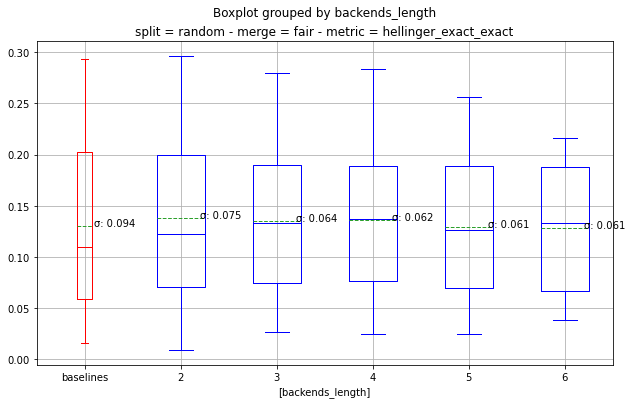

min                       max                             median        \
       2    3    4    5    6     2      3      4      5      6      2     3   
%                                                                             
10   0.7  0.0  0.0  0.0  0.0   1.2    0.0    0.0    0.0    0.0    1.0   0.0   
20   0.7  0.0  0.0  0.0  0.0   3.3    1.5    1.7    0.8    0.0    1.3   0.0   
30   0.7  0.0  0.0  0.0  0.0  16.3   14.9   14.7   19.6   17.5    3.3   1.5   
40   0.7  0.0  0.0  0.0  0.0  28.2   26.0   24.7   29.2   32.5    9.2   7.1   
50   0.7  0.0  0.0  0.0  0.0  41.3   37.5   35.8   39.2   45.0   14.8  13.1   
60   0.7  0.0  0.0  0.0  0.0  47.0   43.4   41.2   43.8   45.0   17.0  15.6   
70   0.7  0.0  0.0  0.0  0.0  53.8   50.5   48.8   53.8   50.0   23.8  22.1   
80   0.7  0.0  0.0  0.0  0.0  80.7   88.9   90.8   96.7  100.0   28.5  26.2   
90   0.7  0.0  0.0  0.0  0.0  97.8   99.6   99.7  100.0  100.0   31.2  29.1   
100  0.7  0.0  0.0  0.0  0.0  99.7  100.0  100.0  100.0  100.0   44.0  40.1   

                      average                         random              \
        4     5     6       2     3     4     5     6      2     3     4   
%                                                                          
10    0.0   0.0   0.0     1.0   0.0   0.0   0.0   0.0    0.9   0.0   0.0   
20    0.0   0.0   0.0     1.8   0.0   0.0   0.0   0.0    1.7   0.4   0.4   
30    1.7   0.8   0.0     3.5   1.8   2.0   0.8   0.0    6.5   5.0   5.1   
40    6.5   8.3  10.0     7.7   5.2   5.8   5.4   7.5   10.2   8.7   8.1   
50   13.3  17.5  17.5    12.7  11.9  11.2  15.4  12.5   16.4  14.0  13.4   
60   15.3  20.4  17.5    19.2  18.1  17.3  22.1  22.5   20.7  18.4  17.1   
70   19.7  24.6  27.5    25.8  23.6  22.0  25.8  30.0   24.7  22.0  20.8   
80   25.2  29.6  32.5    36.3  32.9  31.5  36.2  37.5   32.2  30.5  30.8   
90   27.0  30.8  35.0    43.0  39.4  37.2  40.4  45.0   38.8  38.8  37.0   
100  37.7  40.8  45.0    52.7  49.1  47.7  52.1  50.0   45.4  44.9  46.1   

                 
        5     6  
%                
10    0.0   0.0  
20    0.2   0.0  
30    7.1   5.6  
40   11.1   9.9  
50   17.0  18.1  
60   20.5  20.8  
70   24.2  24.0  
80   35.0  32.9  
90   41.1  40.5  
100  48.7  49.3

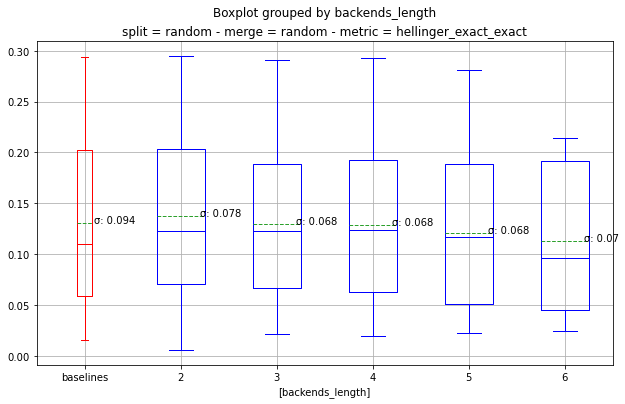

KeyboardInterrupt: 

In [8]:
selectors = ["split_policy", "merge_policy", "metric"]
groupers = ["backends_length"] #["none", "circuit", "backends_length"]

import ipywidgets as widgets
from IPython.display import display

pd.set_option('display.max_columns', 100)  # Set maximum number of columns to display

def display_dataframe(df):
    return display(df)


for group in groupers:
    dds = d_exps.groupby(selectors)
    for dd in dds:
        fig, ax = plt.subplots(figsize=(10, 6))
        name = dd[0]
        dd = dd[1]
        title = ""
        for i, s in enumerate(selectors):
            title += s + " = " + name[i] + " - "

        title = title[:-3]
        title = title.replace("_policy", "").replace("_distance", "")
        
        if group == "none":
            d_baselines[['distance']].boxplot(ax=ax, showmeans=True, meanline=True, color=baselines_color)
            dd[['distance']].boxplot(ax=ax, showmeans=True, meanline=True, color=exps_color, positions=[2])
            
            ax.annotate("σ: "+str(round(d_baselines["distance"].std(),3)), xy=(1, d_baselines["distance"].mean()), xytext=(1.1, d_baselines["distance"].mean()))
            ax.annotate("σ: "+str(round(dd["distance"].std(),3)), xy=(2, dd["distance"].mean()), xytext=(2.1, dd["distance"].mean()))
            
            ax.set_xticklabels(['baselines', 'experiments'])
            
        else:
            
            dd[[group,'distance']].boxplot(ax=ax, showmeans=True, meanline=True, by=group, color=exps_color, positions=[i+1 for i in range(1,len(dd[group].unique())+1)])
            d_baselines[['circuit','distance']].boxplot(ax=ax, showmeans=True, meanline=True, color=baselines_color, positions=[1])
            
            ax.annotate("σ: "+str(round(d_baselines["distance"].std(),3)), xy=(1, d_baselines["distance"].mean()), xytext=(1.1, d_baselines["distance"].mean()))
            for i, g in enumerate(dd[group].unique()):
                ax.annotate("σ: "+str(round(dd[dd[group] == g]["distance"].std(),3)), xy=(i+2, dd[dd[group] == g]["distance"].mean()), xytext=(i+2.2, dd[dd[group] == g]["distance"].mean()))
                
            
            ax.set_xticklabels([str(i) for i in dd[group].unique()] + ['baselines'])
        
        
        ax.set_title(title)
        
        plt.show()
        if group == "none":
            get_percentages(d_baselines, dd)
        else:
            dfs = {}
            for g in dd[group].unique():
                dfs[g] = round(get_percentages(d_baselines, dd[dd[group] == g]),1)
        
            dfs = pd.concat(dfs, axis=1, keys=dd[group].unique()).reset_index()
            
            dfs = dfs.rename(columns={"index": "%"})
            dfs = dfs.set_index("%")
            
            dfs = dfs.swaplevel(axis=1).sort_index(axis=1)
            dfs = dfs[["min", "max", "median", "average", "random"]]
            
            display_dataframe(dfs)
            
            print("\n\n\n")


In [ ]:
selectors = ["split_policy", "merge_policy", "metric"]
groupers = ["backends_length"] #["none", "circuit", "backends_length"]

import ipywidgets as widgets
from IPython.display import display

pd.set_option('display.max_columns', 100)  # Set maximum number of columns to display

def display_dataframe(df):
    return display(df)


for group in groupers:
    dds = d_exps.groupby(selectors)
    for dd in dds:
        fig, ax = plt.subplots(figsize=(10, 6))
        name = dd[0]
        dd = dd[1]
        title = ""
        for i, s in enumerate(selectors):
            title += s + " = " + name[i] + " - "

        title = title[:-3]
        title = title.replace("_policy", "").replace("_distance", "")
        
        if group == "none":
            d_baselines[['distance']].boxplot(ax=ax, showmeans=True, meanline=True, color=baselines_color)
            dd[['distance']].boxplot(ax=ax, showmeans=True, meanline=True, color=exps_color, positions=[2])
            
            ax.annotate("σ: "+str(round(d_baselines["distance"].std(),3)), xy=(1, d_baselines["distance"].mean()), xytext=(1.1, d_baselines["distance"].mean()))
            ax.annotate("σ: "+str(round(dd["distance"].std(),3)), xy=(2, dd["distance"].mean()), xytext=(2.1, dd["distance"].mean()))
            
            ax.set_xticklabels(['baselines', 'experiments'])
            
        else:
            
            dd[[group,'distance']].boxplot(ax=ax, showmeans=True, meanline=True, by=group, color=exps_color, positions=[i+1 for i in range(1,len(dd[group].unique())+1)])
            d_baselines[['circuit','distance']].boxplot(ax=ax, showmeans=True, meanline=True, color=baselines_color, positions=[1])
            
            ax.annotate("σ: "+str(round(d_baselines["distance"].std(),3)), xy=(1, d_baselines["distance"].mean()), xytext=(1.1, d_baselines["distance"].mean()))
            for i, g in enumerate(dd[group].unique()):
                ax.annotate("σ: "+str(round(dd[dd[group] == g]["distance"].std(),3)), xy=(i+2, dd[dd[group] == g]["distance"].mean()), xytext=(i+2.2, dd[dd[group] == g]["distance"].mean()))
                
            
            ax.set_xticklabels([str(i) for i in dd[group].unique()] + ['baselines'])
        
        
        ax.set_title(title)
        
        plt.show()
        if group == "none":
            get_percentages(d_baselines, dd)
        else:
            dfs = {}
            for g in dd[group].unique():
                dfs[g] = round(get_percentages(d_baselines, dd[dd[group] == g]),1)
        
            dfs = pd.concat(dfs, axis=1, keys=dd[group].unique()).reset_index()
            
            dfs = dfs.rename(columns={"index": "%"})
            dfs = dfs.set_index("%")
            
            dfs = dfs.swaplevel(axis=1).sort_index(axis=1)
            dfs = dfs[["min", "max", "median", "average", "random"]]
            
            display_dataframe(dfs)
            
            print("\n\n\n")


### per circuit analysis:

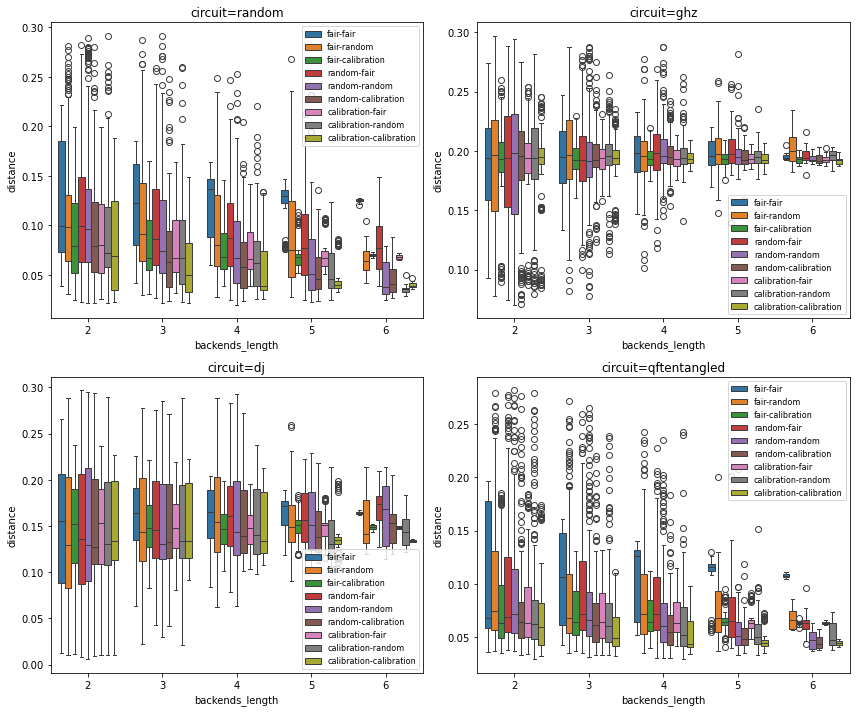

In [8]:
%matplotlib inline

import seaborn as sns

df=d_exps.copy()
df["sm_policy"]=df['split_policy'].apply(lambda x: x.replace("_policy","-")) +df['merge_policy'].apply(lambda x: x.replace("_policy",""))

fig,axs=plt.subplots(2,2,figsize=(12,10))
axs=axs.ravel()

for ii,circname in enumerate(set(d_exps["circuit"])):
    df_loc=df.loc[df["circuit"]==circname]
    sns.boxplot(x = df_loc['backends_length'], 
                y = df_loc['distance'], 
                hue = df_loc['sm_policy'], 
                palette = 'tab10',ax=axs[ii])
    axs[ii].set_title(f"circuit={circname}")
    axs[ii].legend(fontsize=8)
plt.tight_layout()

/tmp/ipykernel_11390/875431501.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = df_loc['backend'],
/tmp/ipykernel_11390/875431501.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = df_loc['backend'],
/tmp/ipykernel_11390/875431501.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = df_loc['backend'],
/tmp/ipykernel_11390/875431501.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = df_loc['backend'],


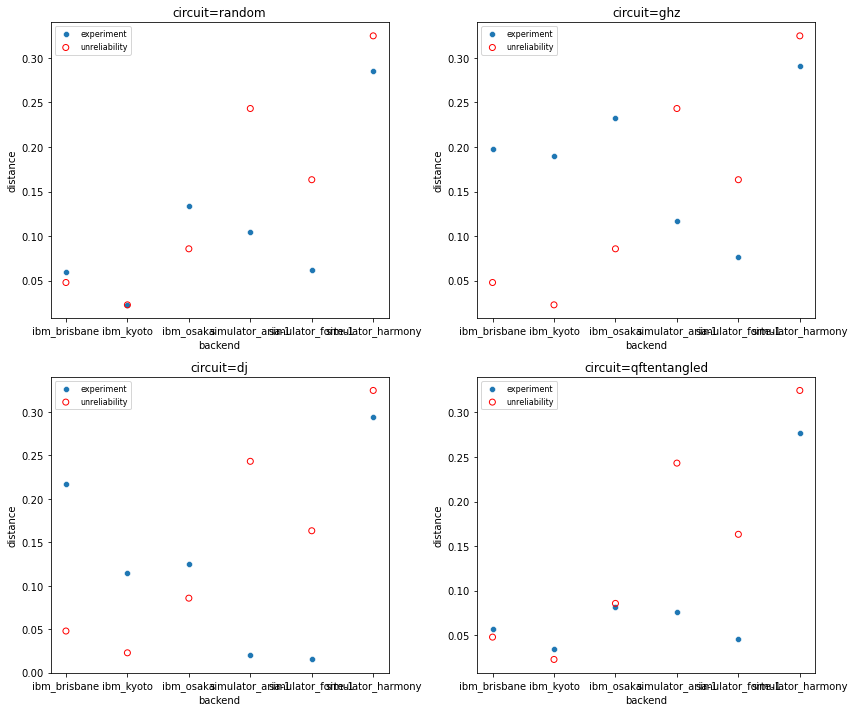

In [69]:
%matplotlib inline
import seaborn as sns

df=d_baselines.copy()

#d_baselines[['backend','distance']].boxplot(ax=ax, showmeans=True, meanline=True, by='backend', color=baselines_color)
#plt.show()
#d_baselines[['backend','distance']].groupby('backend').describe()

fig,axs=plt.subplots(2,2,figsize=(12,10))
axs=axs.ravel()
ii=0
for ii,circname in enumerate(set(d_baselines["circuit"])):
    df_loc=df.loc[df["circuit"]==circname]
    #sns.boxplot(x = df_loc['backend'], 
    #            y = df_loc['distance'], 
#   #             hue = df_loc['backend'], 
    #            palette = 'tab10',ax=axs[ii])
    sns.scatterplot(x = df_loc['backend'], 
                y = df_loc['distance'], 
#                hue = df_loc['backend'], 
                palette = 'tab10',ax=axs[ii],label="experiment")
    axs[ii].scatter(dict_dists.keys(),dict_dists.values(),label="unreliability", facecolors='none', edgecolors='red')
    axs[ii].set_title(f"circuit={circname}")
    axs[ii].legend(fontsize=8)
plt.tight_layout()


So, we observe a strong dependence on the specific type of circuit

### reliability as a function of real time

In [34]:
exps = os.listdir('../../Calibrator/calibrations/')
exps.remove("ground_truth.json")
exps.remove("settings.json")
exps.remove("circuits")
exps = sorted(exps, key=lambda x: datetime.datetime.strptime(x, "%d-%m-%Y--%H-%M-%S"))
exps_dates=[datetime.datetime.strptime(x, "%d-%m-%Y--%H-%M-%S") for x in exps]
#print(exps_dates)

dist_list={}
import json

for ei, val in enumerate(exps):
    reliabs=json.load(open(f'../../Calibrator/calibrations/{val}/calibrations/reliability.json',"r"))
    dic={}
    for kv in reliabs:
        dic[kv[0]]=kv[1]
    for k in dic.keys():
        if k in dist_list.keys():
            dist_list[k].append(dic[k])
        else:
            dist_list[k]=[dic[k],]

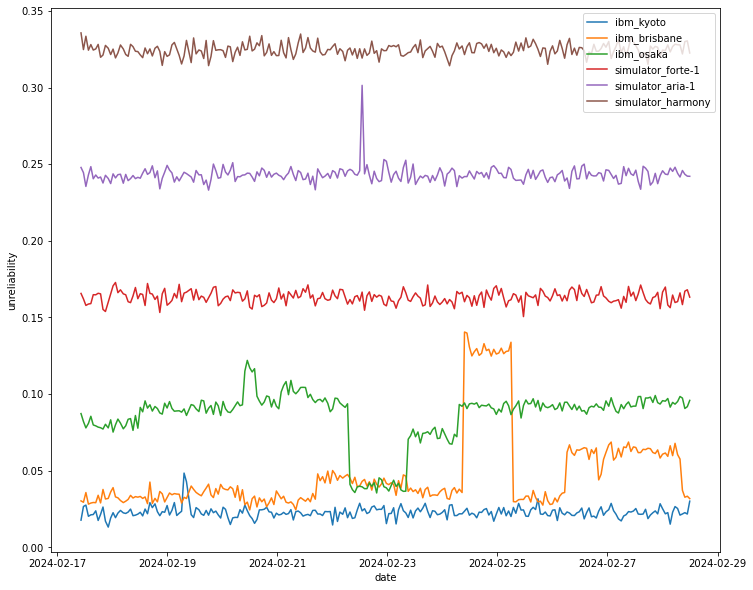

In [59]:
%matplotlib inline
import numpy as np

fig,ax=plt.subplots(1,1,figsize=(12,10))

dict_dists={}
for k,v in dist_list.items():
    dict_dists[k]=np.mean(1./np.array(v))
    ax.plot(exps_dates,1./np.array(v),label=f"{k}")
    
#ax.set_yscale("log")
ax.set_xlabel("date")
ax.set_ylabel("unreliability")
plt.legend()

### Distance of each machine for fixed circuit

In [44]:
#exps = os.listdir('../../Calibrator/calibrations/')
#exps.remove("ground_truth.json")
#exps.remove("settings.json")
#exps.remove("circuits")
#exps = sorted(exps, key=lambda x: datetime.datetime.strptime(x, "%d-%m-%Y--%H-%M-%S"))
#exps_dates=[datetime.datetime.strptime(x, "%d-%m-%Y--%H-%M-%S") for x in exps]
##print(exps_dates)
#
#ground_truth_fname='../../Calibrator/calibrations/ground_truth.json'
#
#dist_list={}
#import json
#
#for ei, val in enumerate(exps):
#    reliabs=json.load(open(f'../../Calibrator/calibrations/{val}/calibrations/reliability.json',"r"))
#    dic={}
#    for kv in reliabs:
#        dic[kv[0]]=kv[1]
#    for k in dic.keys():
#        if k in dist_list.keys():
#            dist_list[k].append(dic[k])
#        else:
#            dist_list[k]=[dic[k],]

### Covariance of distributions for fixed ground truth benchmark

### is PCA weighted average better than full weighted Hellinger average?